## Setup

Begin with importing libraries required for initial data load and data wrangling, as well as visualization.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

Next, we source three files and construct two primary data sets.

* The first data set will contain all countries and the GTMI scores they received. This includes the GTEI (Enablement) score and specifically scores related to employee training.
* The second data set will include informaiton about the success of projects completed within the contries.
* The third will include GDP scores, which will be used as an indepenednt variable for reducing Ommitted Variable Bias (OVB).

We start with the GovTech GTMI data.

In [2]:
## GovTech GTMI Scoring Data
# Open Excel data file
filename = 'Data/WBG_GovTech Dataset_Oct2022.xlsx'
govtech_raw = pd.read_excel(filename, sheet_name = 'CG_GTMI_Data', nrows=396)

# Remove 2020 data rows
govtech_2022 = govtech_raw[govtech_raw.Year == 2022]

# Select columns of interest
govtech = govtech_2022[['Code', 'Economy', 'Population', 'Level', 'Reg', 
                        'Grp', 'GTMI', 'CGSI', 'PSDI', 'DCEI', 'GTEI',
                        'I-45', 'I-45.4', 'I-45.5', 'I-45.5.1', 'I-45.5.3',
                        'I-45.6', 'I-45.7']]

# Rename columns for easier reference within the analysis
colnames = {'Economy':'Country', 'Level':'IncomeLevel', 'Reg':'Region',
            'Grp':'Group', 'I-45':'DS_Strategy_Program', 'I-45.4':'FocusArea',
            'I-45.5':'DSProgram', 'I-45.5.1':'DSProgramType', 
            'I-45.5.3':'DSProgramMandatory', 'I-45.6':'DSProgramExternal',
            'I-45.7':'DSProgramPublished'}
govtech = govtech.rename(columns = colnames)

# Show first lines to confirm data
govtech.head()

,Code,Country,Population,IncomeLevel,Region,Group,GTMI,CGSI,PSDI,DCEI,GTEI,DS_Strategy_Program,FocusArea,DSProgram,DSProgramType,DSProgramMandatory,DSProgramExternal,DSProgramPublished
1,AFG,Afghanistan,40099.462,L,SAR,C,0.353608,0.414570,0.546835,0.131361,0.321668,2,1,1,3,1,1,0
3,ALB,Albania,2854.710,UM,ECA,A,0.752084,0.706767,0.857460,0.735200,0.708908,1,3,0,0,0,0,0
5,DZA,Algeria,44177.969,LM,MNA,B,0.501913,0.493249,0.689239,0.309428,0.515738,1,1,1,1,1,2,0
7,AND,Andorra,79.034,H,ECA,C,0.252925,0.195779,0.554948,0.041284,0.219689,0,0,0,0,0,0,0
9,AGO,Angola,34503.774,LM,AFR,C,0.446879,0.435822,0.564652,0.220606,0.566436,1,2,1,2,0,2,2


In [3]:
# Several of the columns get read in as objects instead of numeric.
# Need to convert these to numeric for evaluation.
govtech['DSProgram'] = pd.to_numeric(govtech.DSProgram)
govtech['DSProgramType'] = pd.to_numeric(govtech.DSProgramType)
govtech['DSProgramMandatory'] = pd.to_numeric(govtech.DSProgramMandatory)
govtech['DSProgramExternal'] = pd.to_numeric(govtech.DSProgramExternal)
govtech['DSProgramPublished'] = pd.to_numeric(govtech.DSProgramPublished)
govtech.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198 entries, 1 to 395
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Code                 198 non-null    object 
 1   Country              198 non-null    object 
 2   Population           198 non-null    float64
 3   IncomeLevel          198 non-null    object 
 4   Region               198 non-null    object 
 5   Group                198 non-null    object 
 6   GTMI                 198 non-null    float64
 7   CGSI                 198 non-null    float64
 8   PSDI                 198 non-null    float64
 9   DCEI                 198 non-null    float64
 10  GTEI                 198 non-null    float64
 11  DS_Strategy_Program  198 non-null    int64  
 12  FocusArea            198 non-null    int64  
 13  DSProgram            198 non-null    int64  
 14  DSProgramType        198 non-null    int64  
 15  DSProgramMandatory   198 non-null    int64  


Next, we bring in the GovTech projects data, focusing on the project succes rate variables.

In [4]:
## GovTech Projects Data
filename = 'Data/WBG_DG-GovTech_Projects_Oct2022.xlsx'
projects_raw = pd.read_excel(filename, sheet_name = 'DG Projects', nrows=1449)

# Select columns of interest
projects = projects_raw[['Project ID', 'Region', 'Country', 'ICR Out', 'IEG Out']]
# Rename columns to simplify reference in analysis
colnames = {'Project ID':'ProjectID', 'ICR Out':'ICROutcome', 'IEG Out':'IEGOutcome'}
projects = projects.rename(columns = colnames)

# We are interested in the success rate of projects, so we remove
# any projects that do not have either an ICR rating or an IEG rating.
# We do this by filtering each coloumn in turn, then joining back together.

# Create separate project data sets
projectsICR = projects[['ProjectID', 'Region', 'Country', 'ICROutcome']]
projectsIEG = projects[['ProjectID', 'Region', 'Country', 'IEGOutcome']]

# Drop missing values form each
projectsICR = projectsICR.dropna()
projectsIEG = projectsIEG.dropna()

# Put them back together with a full outer join
projects = projectsICR.merge(projectsIEG, on=('ProjectID', 'Region', 'Country'),
                                  how='outer', suffixes=('_ICR', '_IEG'))

# Show the first few lines to confirm the data
projects.head()

,ProjectID,Region,Country,ICROutcome,IEGOutcome
0,P006661,LCR,Chile,S,S
1,P078359,ECA,Turkiye,HS,HS
2,P058512,ECA,Bosnia and Herzegovina,S,S
3,P079708,SAR,India,S,S
4,P102398,EAP,Lao People's Democratic Republic,HS,S


Finally, we will bring in the GDP data.

In [5]:
## GDP Data
filename = 'Data/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_4770391.csv'
gdp_raw = pd.read_csv(filename, header=2)

# Select columns of interest
gdp = gdp_raw[['Country Name', 'Country Code', '2021']]
# Rename columns
gdp = gdp.rename(columns={'Country Name':'Country', 'Country Code':'Code', '2021':'GDP2021'})

# Show the first few lines to confirm the data
gdp.head()

,Country,Code,GDP2021
0,Aruba,ABW,3.126019e+09
1,Africa Eastern and Southern,AFE,1.080712e+12
2,Afghanistan,AFG,1.478686e+10
3,Africa Western and Central,AFW,8.401873e+11
4,Angola,AGO,6.740429e+10


## Prep GTMI Data for Analysis
Next, we need to prep the GTMI data for analysis through Lienar and Logit regression. Steps we need to complete here, include:
1. Add the GDP data as an additional variable.
2. Convert IncomeLevel to a factor variable to use for OVB.

Ultimately, IncomeLevel, Population, and GDP will all be used as control variables for OVB. The values in GTEI, DS_Strategy_Program, FocusArea, DSProgram, DSProgramType, DSProgramMandatory, DSProgramExternal, and DSProgramPublished will be used as independent varaibles of interest in an attempt to predict the GTMI score. I.e. do these enablement and Tech Skills training values influence the overall Tech Maturity of a government.

In [6]:
# Merge the GDP data into the GovTech GTMI data.
govtech_gdp = govtech.merge(gdp, on=('Code'), how='left', suffixes=('', '_gdp'))

# Drop the redundant Country value brought into the data set
govtech_gdp = govtech_gdp.drop(columns=['Country_gdp'])

# Did the merge result in any GTMI countries missing a GDP value?
print(np.mean(govtech_gdp.GDP2021 <= 0))

# Show results
govtech_gdp.head()

0.0


,Code,Country,Population,IncomeLevel,Region,Group,GTMI,CGSI,PSDI,DCEI,GTEI,DS_Strategy_Program,FocusArea,DSProgram,DSProgramType,DSProgramMandatory,DSProgramExternal,DSProgramPublished,GDP2021
0,AFG,Afghanistan,40099.462,L,SAR,C,0.353608,0.414570,0.546835,0.131361,0.321668,2,1,1,3,1,1,0,1.478686e+10
1,ALB,Albania,2854.710,UM,ECA,A,0.752084,0.706767,0.857460,0.735200,0.708908,1,3,0,0,0,0,0,1.825579e+10
2,DZA,Algeria,44177.969,LM,MNA,B,0.501913,0.493249,0.689239,0.309428,0.515738,1,1,1,1,1,2,0,1.630444e+11
3,AND,Andorra,79.034,H,ECA,C,0.252925,0.195779,0.554948,0.041284,0.219689,0,0,0,0,0,0,0,3.330282e+09
4,AGO,Angola,34503.774,LM,AFR,C,0.446879,0.435822,0.564652,0.220606,0.566436,1,2,1,2,0,2,2,6.740429e+10


Now we can convert the IncomeLevel column to a categorical variable to use for reducing OVB.

In [7]:
# Define the categories and corresponding codes
categories = ['L', 'LM', 'UM', 'H']
codes = [0, 1, 2, 3]

# Create a categorical data type to convert the existing variable
from pandas.api.types import CategoricalDtype
cat_dtype = CategoricalDtype(
    categories=['L', 'LM', 'UM', 'H'], ordered=True)

# Convert the IncomeLevel column to categorical
govtech_gdp['IncomeLevel'] = govtech_gdp['IncomeLevel'].astype(cat_dtype)

# Outcome should look no different
print(govtech_gdp['IncomeLevel'].head(10))

# But the type of the column is now categorical
print(type(govtech_gdp.IncomeLevel.array))

0     L
1    UM
2    LM
3     H
4    LM
5     H
6    UM
7    UM
8     H
9     H
Name: IncomeLevel, dtype: category
Categories (4, object): ['L' < 'LM' < 'UM' < 'H']
<class 'pandas.core.arrays.categorical.Categorical'>


The GovTech GTMI data is now ready for regression analysis.

## Prep Projects Data for Analysis
The projects data includes two key varaibles that we want to predict: ICROutcome and IEGOutcome. These are two separate categorical values that are based on independent evaluations of individual technology projects subsidized by the World Bank Group (WBG). We will want to use the same independent predictor variables from the GTMI data to predict project success, i.e. does Tech Skills enablement influence the success of technology projects.

There are a number of challenges with merging the Projects and GovTech GTMI data:
* Not all projects have recorded outcome variables. We already removed projects where neither outcome variable has a value. Where only one is missing, we will assume an unsatisfactory outcome for that variable.
* Outcome variables are currently categorical and will need to be altered to act as binary variables for Logit regression.
* Not all countries have recorded projects from the WBG. These countries will need to be removed from the data set.
* We need to include the same independent variables for reducing OVB.
* The projects data has a Country name, but NOT a Coutnry Code. This reduces the matches that we will get, and we will need to provide additional information.

For each Oucome variable, there are 6 possible values: HS, S, MS, MU, U, HU. let's start by getting a perspective of the distribution of the data based on each variable.



In [8]:
projects.head()

,ProjectID,Region,Country,ICROutcome,IEGOutcome
0,P006661,LCR,Chile,S,S
1,P078359,ECA,Turkiye,HS,HS
2,P058512,ECA,Bosnia and Herzegovina,S,S
3,P079708,SAR,India,S,S
4,P102398,EAP,Lao People's Democratic Republic,HS,S


Distribution of ICROutcome values

Text(0.5, 0.98, 'Distribution of ICR Outcome Scores')

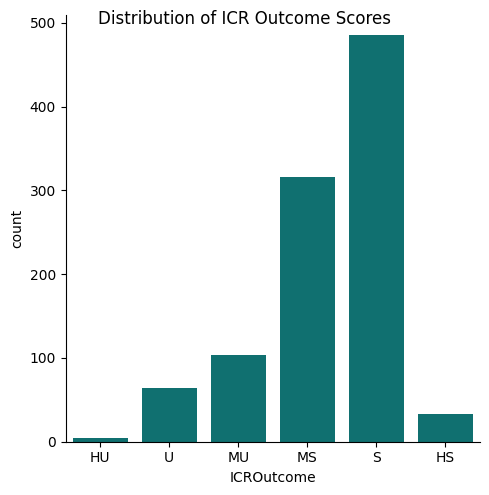

In [9]:
# Distribution of ICROutcome values
category_order = ['HU', 'U', 'MU', 'MS', 'S', 'HS']
icrplot = sns.catplot(x='ICROutcome', data=projects, kind='count', order=category_order, color='teal')
icrplot.fig.suptitle('Distribution of ICR Outcome Scores')

In [10]:
# Export the plot to a file for inclusion in the research note
icrplot.savefig(r'ICRDist.png')

Distribution of IEGOutcome values

Text(0.5, 0.98, 'Distribution of IEG Outcome Scores')

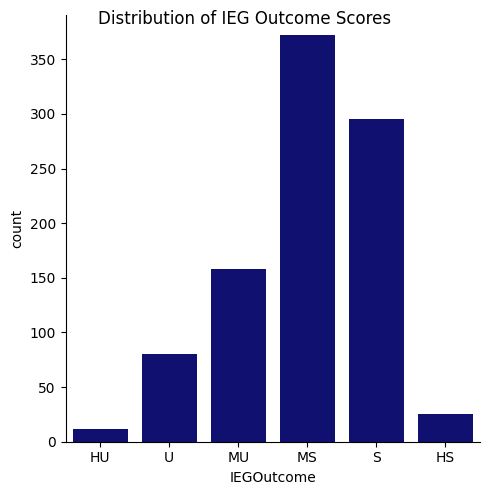

In [11]:
# Distribution of IEGOutcome values
iegplot = sns.catplot(x='IEGOutcome', data=projects, kind='count', order=category_order, color='navy')
iegplot.fig.suptitle('Distribution of IEG Outcome Scores')

In [12]:
# Export the plot to a file for inclusion in the research note
iegplot.savefig(r'IEGDist.png')

These charts provide the overall distribution of each varaible. Now we can reduce them to bivariate variables for logistic regression. Any satisfactory evaluation will get a value of 1, any unsatisfactory evaluation will get a value of 0.

In [13]:
# Create binary values for ICROutcome and IEGOutcome
projects['ICROutcomeB'] = np.where(projects['ICROutcome'].isin(['HS', 'S', 'MS']), 1, 0)
projects['IEGOutcomeB'] = np.where(projects['IEGOutcome'].isin(['HS', 'S', 'MS']), 1, 0)

# Check the totals for each binary variable
print('Total Satisfactory ICR Ratings: ' + str(np.sum(projects.ICROutcomeB)))
print('Total Satisfactory IEG Ratings: ' + str(np.sum(projects.IEGOutcomeB)))

# Display the first few columns of the data set
projects.head(10)

Total Satisfactory ICR Ratings: 834
Total Satisfactory IEG Ratings: 692


,ProjectID,Region,Country,ICROutcome,IEGOutcome,ICROutcomeB,IEGOutcomeB
0,P006661,LCR,Chile,S,S,1,1
1,P078359,ECA,Turkiye,HS,HS,1,1
2,P058512,ECA,Bosnia and Herzegovina,S,S,1,1
3,P079708,SAR,India,S,S,1,1
4,P102398,EAP,Lao People's Democratic Republic,HS,S,1,1
5,P144871,ECA,Croatia,MS,MS,1,1
6,P147740,AFR,Cote d'Ivoire,S,MS,1,1
7,P064536,ECA,Bulgaria,S,MS,1,1
8,P038947,LCR,Brazil,S,S,1,1
9,P005741,MNA,Tunisia,S,S,1,1


Now we need to join the project results to the GTMI results so that we can leverage the Tech Enablement variables for regression. However, we only have a Country name variable in the __projects__ data, not a Country _Code_. We can start by adding Country codes using the _Code_ and _Country_ values from the __govtech__ data, then fill in where we Country names are not matching.

We start by creating a lookup table with Country names and Country Codes from the more complete __govtech__ data set. We can then merge this to our __projects__ data.

In [14]:
# Create a set of Country names and Country Codes from the govtech data.
country_lookup = govtech[['Country', 'Code']]

# Join this to the projects data based on the Country name
projectscd = projects.merge(country_lookup, on='Country', how='left', suffixes=('_prj', '_gt'))

# preview the data
projectscd.head(10)


,ProjectID,Region,Country,ICROutcome,IEGOutcome,ICROutcomeB,IEGOutcomeB,Code
0,P006661,LCR,Chile,S,S,1,1,CHL
1,P078359,ECA,Turkiye,HS,HS,1,1,NaN
2,P058512,ECA,Bosnia and Herzegovina,S,S,1,1,BIH
3,P079708,SAR,India,S,S,1,1,IND
4,P102398,EAP,Lao People's Democratic Republic,HS,S,1,1,NaN
5,P144871,ECA,Croatia,MS,MS,1,1,HRV
6,P147740,AFR,Cote d'Ivoire,S,MS,1,1,NaN
7,P064536,ECA,Bulgaria,S,MS,1,1,BGR
8,P038947,LCR,Brazil,S,S,1,1,BRA
9,P005741,MNA,Tunisia,S,S,1,1,TUN


There is a small set of Countries in the __projects__ data that do not match to the country names in the __govtech__ data. There is no easy way to handle this, so our best option is to manually create additional lookup values.

In [15]:
# Which countries did not get picked up?
projectscd[pd.isna(projectscd['Code'])]['Country'].unique()

array(['Turkiye', "Lao People's Democratic Republic", "Cote d'Ivoire",
       'Egypt, Arab Republic of', 'Central Africa', 'Africa',
       'Congo, Democratic Republic of', 'Congo, Republic of',
       'Eastern and Southern Africa', 'Yemen, Republic of',
       'Sao Tome and Principe', 'Gambia, The',
       'Western and Central Africa',
       'Venezuela, Republica Bolivariana de', 'Caribbean',
       'Iran, Islamic Republic of', 'OECS Countries'], dtype=object)

In [16]:
# Manually create a lookup data frame with the additional values
add_lookup = pd.DataFrame({'Country':['Turkiye', 'Lao People\'s Democratic Republic', 'Cote d\'Ivoire',
                                   'Egypt, Arab Republic of', 'Central Africa', 'Africa', 'Congo, Democratic Republic of',
                                   'Congo, Republic of', 'Eastern and Southern Africa', 'Yemen, Republic of',
                                   'Sao Tome and Principe', 'Gambia, The', 'Western and Central Africa',
                                   'Venezuela, Republica Bolivariana de', 'Caribbean', 'Iran, Islamic Republic of',
                                   'OECS Countries'], 
                        'Code':['TUR', 'LAO', 'CIV', 'EGY', 'CAF', 'UNK', 'COD', 'COG', 'UNK', 'YEM', 
                                'STP', 'GMB', 'UNK', 'VEN', 'UNK', 'IRN', 'UNK']})

# Let's add these new values to the original lookup data frame
country_lookup_full = pd.concat([country_lookup, add_lookup])

# Repeat the previous merge effort with the longer list of country codes
projectscd = projects.merge(country_lookup_full, on='Country', how='left', suffixes=('_prj', '_add'))

# Validate we no longer have any missing Codes
print(np.sum(pd.isna(projectscd.Code)))

# preview the data
projectscd.head(10)

0


,ProjectID,Region,Country,ICROutcome,IEGOutcome,ICROutcomeB,IEGOutcomeB,Code
0,P006661,LCR,Chile,S,S,1,1,CHL
1,P078359,ECA,Turkiye,HS,HS,1,1,TUR
2,P058512,ECA,Bosnia and Herzegovina,S,S,1,1,BIH
3,P079708,SAR,India,S,S,1,1,IND
4,P102398,EAP,Lao People's Democratic Republic,HS,S,1,1,LAO
5,P144871,ECA,Croatia,MS,MS,1,1,HRV
6,P147740,AFR,Cote d'Ivoire,S,MS,1,1,CIV
7,P064536,ECA,Bulgaria,S,MS,1,1,BGR
8,P038947,LCR,Brazil,S,S,1,1,BRA
9,P005741,MNA,Tunisia,S,S,1,1,TUN


Important to note is that in the manual lookup data, there were some Country names that could not be reconciled. Some of these projects referred to groups of countries, of countries that do not appear in the __govtech__ GTMI data. We labeled these with a _Code_ of 'UNK' for 'Unknown'. Without a clear conuntry to reconcile to, we need to drop these values.

In [17]:
print('Total projects: ' + str(len(projectscd)))
print('Projects with unknown countries: ' + str(np.sum(projectscd.Code == 'UNK')))

# Drop the projects with Unknown country codes
projectscd = projectscd[projectscd['Code'] != 'UNK']
print('Remaining projects: ' + str(len(projectscd)))

Total projects: 1024
Projects with unknown countries: 25
Remaining projects: 999


Our __projectscd__ data now has country codes. This allows us to join the data to out __govtech_gdp__ data, getting important independent variables from which we can then perform logit regression on the two _Outcome_ variables.

In [18]:
# Merge the projects and govtech data
projects_gtmi = projectscd.merge(govtech_gdp, on='Code', how='left', suffixes=('_prj', ''))
# Drop the Region and Country fields from projects in favor of the more complete govtech
projects_gtmi = projects_gtmi.drop(columns=['Region_prj', 'Country_prj'])

# Examine the resulting data set
projects_gtmi


,ProjectID,ICROutcome,IEGOutcome,ICROutcomeB,IEGOutcomeB,Code,Country,Population,IncomeLevel,Region,...,DCEI,GTEI,DS_Strategy_Program,FocusArea,DSProgram,DSProgramType,DSProgramMandatory,DSProgramExternal,DSProgramPublished,GDP2021
0,P006661,S,S,1,1,CHL,Chile,19493.184,H,LCR,...,0.681820,0.728947,2,2,1,2,1,1,0,3.170585e+11
1,P078359,HS,HS,1,1,TUR,Türkiye,84775.404,UM,ECA,...,0.847791,0.846981,2,3,1,2,1,2,1,8.190352e+11
2,P058512,S,S,1,1,BIH,Bosnia and Herzegovina,3270.943,UM,ECA,...,0.159717,0.176278,0,0,0,0,0,0,0,2.336536e+10
3,P079708,S,S,1,1,IND,India,1407563.842,LM,SAR,...,0.954961,0.903784,2,3,1,2,1,2,2,3.176295e+12
4,P102398,HS,S,1,1,LAO,Lao PDR,7425.057,LM,EAP,...,0.432448,0.369742,0,0,0,0,0,0,0,1.882715e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,P006669,NaN,HS,0,1,CHL,Chile,19493.184,H,LCR,...,0.681820,0.728947,2,2,1,2,1,1,0,3.170585e+11
995,P007457,NaN,S,0,1,JAM,Jamaica,2827.695,UM,LCR,...,0.517516,0.421741,1,0,1,1,1,1,0,1.465759e+10
996,P044387,NaN,MS,0,1,ARM,Armenia,2790.974,UM,ECA,...,0.706000,0.630724,0,0,0,0,0,0,0,1.386141e+10
997,P008413,NaN,S,0,1,GEO,Georgia,3757.980,UM,ECA,...,0.499167,0.630316,0,0,0,0,0,0,0,1.862937e+10


## Controlling for OVB
With the large number of countries considered in this analysis, there is substantial risk of Omitted Variable Bias. I have attempted to control for OVB through the introduction of three varaibles not directly related to the varaibles of interest. Each of these, however, can vary across the countries represented. They include Income Level, a categorical variable, Population, and GDP.

In this section, I am examining how each of these variables is distributed across the GTEI scores to assess whether it can be introduced as a control variable. I start with Income Level.

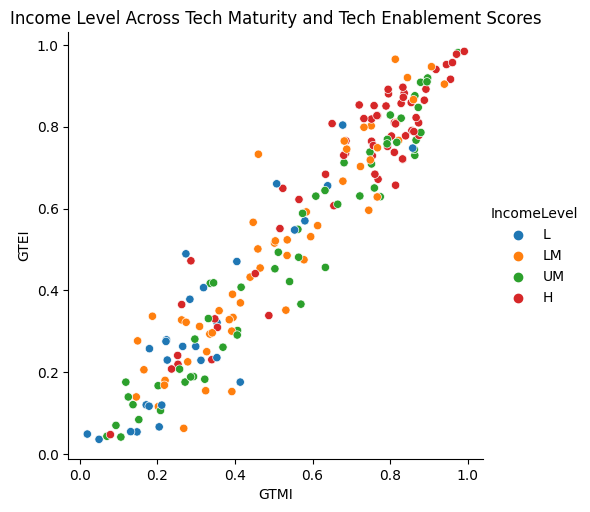

In [19]:
# Create a scatterplot of GTEI against GTMI with IncomeLevel as color
ILScatter = sns.relplot(x='GTMI', y='GTEI', data=govtech_gdp, kind='scatter', hue='IncomeLevel')
ILScatter.set(title='Income Level Across Tech Maturity and Tech Enablement Scores')

In [20]:
# Save to file for use in documentation
ILScatter.savefig(r'ILScatter.png')

Unsurpisingly, the GTEI data appears strongly correlated with the GTMI score, since GTEI is one of 4 composite scores that are used to generate GTMI. In this plot, however, the interesting aspect is that IncomeLevel is generally scattered across the values. This indicates that average Income Level may NOT be an influencing factor for Tech Maturity.

Population and GDP are the other two variables we are interested in examining for OVB. First, let's look at the distribution of the two data sets.

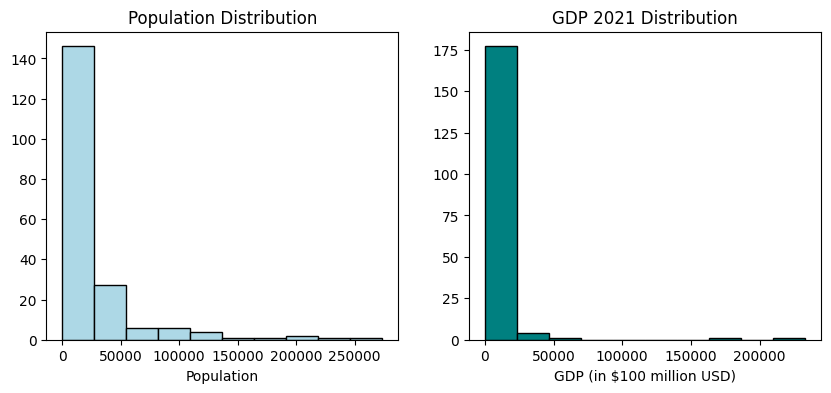

In [21]:
# Start by subsetting just the columns of interest
dfSub = govtech_gdp[['GTMI', 'GTEI', 'Population', 'GDP2021']].copy()
# Population is highly skewed. Let's remove dsome outliers.
dfPopulation = dfSub[dfSub['Population'] <= 300000]
# And for simplicity of understnaidng the data, let's convert GDP to 100s of millions
dfSub['GDPMil'] = dfSub['GDP2021'] / 100000000

# Now plot the distributions of both values
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(dfPopulation['Population'], bins=10, color='lightblue', linewidth=1, edgecolor="black")
ax[0].set_xlabel('Population')
ax[0].set_title('Population Distribution')
ax[1].hist(dfSub['GDPMil'], bins=10, color='teal', linewidth=1, edgecolor="black")
ax[1].set_xlabel('GDP (in $100 million USD)')
ax[1].set_title('GDP 2021 Distribution')
#plt.show()    # prevents plot from being saved to file correctly
# Export the distribution charts for documentation
plt.savefig(r'Pop_GDP_Dist.png')

Both distributions are highly skewed. The outliers could definitely affect the outcome of the regression analysis. Instead, let's consider logartimic calculations on both.

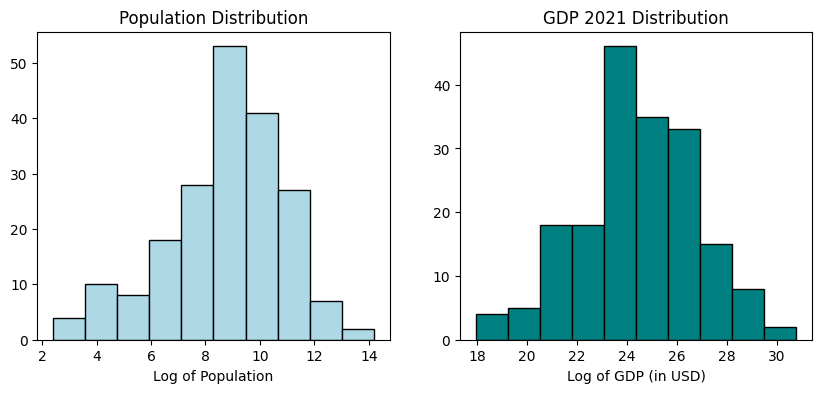

In [22]:
# Calculate logarithmic values for Population and GDP
dfSub['logPopulation'] = np.log(dfSub['Population'])
dfSub['logGDP'] = np.log(dfSub['GDP2021'])

# Replot the distributions based on the logrithmic values
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(dfSub['logPopulation'], bins=10, color='lightblue', linewidth=1, edgecolor="black")
ax[0].set_xlabel('Log of Population')
ax[0].set_title('Population Distribution')
ax[1].hist(dfSub['logGDP'], bins=10, color='teal', linewidth=1, edgecolor="black")
ax[1].set_xlabel('Log of GDP (in USD)')
ax[1].set_title('GDP 2021 Distribution')
# Save to file for inclusion in documentation
plt.savefig(r'log_Pop_GDP_Dist.png')


These distributions look much more usable. Let's take a look at how they influence the GTMI and GTEI scores through scatterplots similar to what we did with IncomeLevel.

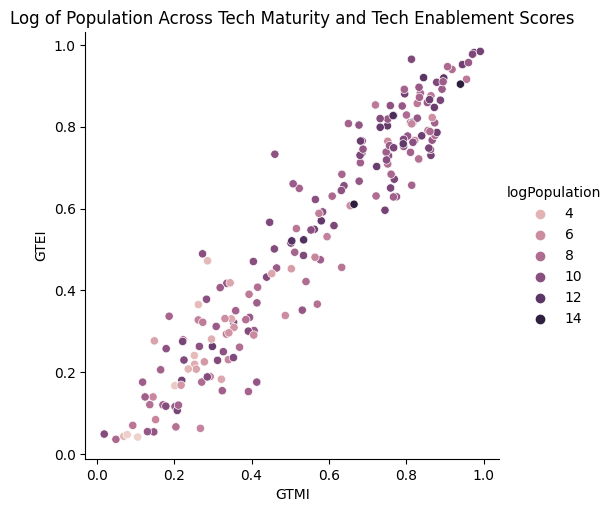

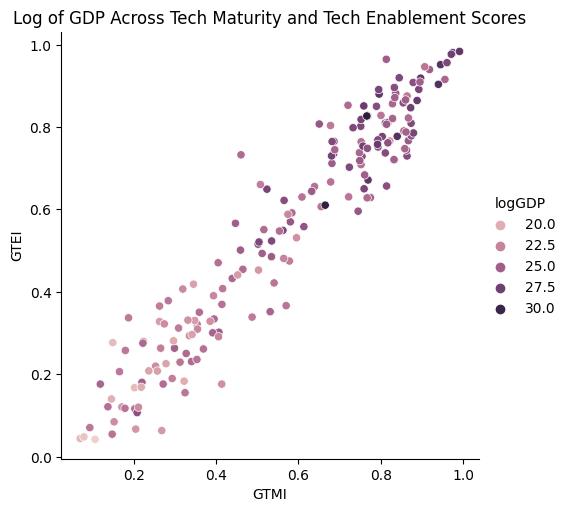

In [23]:
# Create a scatterplot of GTEI against GTMI with log of Population as color
logPopScatter = sns.relplot(x='GTMI', y='GTEI', data=dfSub, kind='scatter', hue='logPopulation')
logPopScatter.set(title='Log of Population Across Tech Maturity and Tech Enablement Scores')
#plt.show()

# Create a scatterplot of GTEI against GTMI with log of GDP as color
logGDPScatter = sns.relplot(x='GTMI', y='GTEI', data=dfSub, kind='scatter', hue='logGDP')
logGDPScatter.set(title='Log of GDP Across Tech Maturity and Tech Enablement Scores')

In [24]:
logPopScatter.savefig(r'logPopScatter.png')
logGDPScatter.savefig(r'logGDPScatter.png')

The scatter plots show a slightly increased concentration of higher population and higher GDP in the upper right. However, the concentrations do not appear significant through visual observation. In general, the values are spread throughout the GTMI and GTEI results. Let's add these logistic values to our primary data set.

In [25]:
# Calculate Log of Popualtion and GDP and add as varaibles to the data frame
govtech_gdp['logPopulation'] = np.log(govtech_gdp['Population'])
govtech_gdp['logGDP'] = np.log(govtech_gdp['GDP2021'])

### Correlation of GTMI to Tech Skills Training
In this first regression analysis, we will perform a regression analysis of the GTMI results based on GTEI and the Tech Skills enablement variables used to generate the GTEI variable. The goal is to assess to what extent that Tech Skills enablement influences the overall Tech maturity of a government organization.

Let's start with a simple correlation between GTMI, GTEI, and the other TechSkills enablement variables.

In [26]:

# We are breaking this into two matrices for simplicity in reading

# Pull out the varaibles of interest from the core data set
columns = ['GTMI', 'GTEI', 'DS_Strategy_Program', 'FocusArea', 'DSProgram', 'DSProgramType']
subset = govtech_gdp[columns].copy()
# Build a matrix
subset.corr()

,GTMI,GTEI,DS_Strategy_Program,FocusArea,DSProgram,DSProgramType
GTMI,1.000000,0.955211,0.686902,0.642714,0.688991,0.716682
GTEI,0.955211,1.000000,0.753738,0.677207,0.735473,0.742587
DS_Strategy_Program,0.686902,0.753738,1.000000,0.735846,0.763739,0.728100
FocusArea,0.642714,0.677207,0.735846,1.000000,0.687912,0.656290
DSProgram,0.688991,0.735473,0.763739,0.687912,1.000000,0.916313
DSProgramType,0.716682,0.742587,0.728100,0.656290,0.916313,1.000000


In [27]:
# And repeat with the remaining data
columns = ['GTMI', 'GTEI', 'DSProgramMandatory', 'DSProgramExternal', 'DSProgramPublished']
subset = govtech_gdp[columns].copy()
subset.corr()

,GTMI,GTEI,DSProgramMandatory,DSProgramExternal,DSProgramPublished
GTMI,1.000000,0.955211,0.597771,0.656245,0.423575
GTEI,0.955211,1.000000,0.642235,0.698605,0.473223
DSProgramMandatory,0.597771,0.642235,1.000000,0.680191,0.457650
DSProgramExternal,0.656245,0.698605,0.680191,1.000000,0.517175
DSProgramPublished,0.423575,0.473223,0.457650,0.517175,1.000000


Based on the above correlation matrices, it appears the variables with the least correlation with GTMI and GTEI are DSProgramMandatory (indicating whether new employees are required to take the Tech Skills training), and DSProgramPublished (indicating whether the results of the training program are published). We can keep this in mind as we turn to Regression analysis.

### Regression of GTMI on Tech Skills Training
We can start with simple regression.

In [28]:
# Import linregress from SciPy Stats library
from scipy.stats import linregress

# Call a simple regression function with the predictor followed by the dependent variable
model = linregress(govtech_gdp.GTEI, govtech_gdp.GTMI)

# Print results for interpretation
print(f'Intercept: {model.intercept:.4f} ({model.intercept_stderr:.3f})')
print(f'GTEI: {model.slope:.4f} ({model.stderr:.3f})')
print(f'R-Value: {model.rvalue:.4f}')
print(f'R-Squared: {model.rvalue**2:.4f}')
print(f'P-Value: {model.pvalue:.4f}')
print(f'Observations: {govtech_gdp.shape[0]}')


Intercept: 0.0668 (0.012)
GTEI: 0.9053 (0.020)
R-Value: 0.9552
R-Squared: 0.9124
P-Value: 0.0000
Observations: 198


In this simple regression model, the GTEI enablement score has a coefficient of 0.9053 (0.02), indicating that a value of 1 for the GTEI score will increase the GTMI score by 0.9053. However, we have to keep in mind that GTEI and GTMI scores have a range of 0 to 1. Therefore, we could interpret this as an increased value of 0.1 in the GTEI score (enablement) improves the overall Tech Maturity of teh GTMI score by 0.09, or almost 0.1, indicating a very near 1 to 1 correlation.

We can illustrate this with our earlier scatterplot and including the regression line.

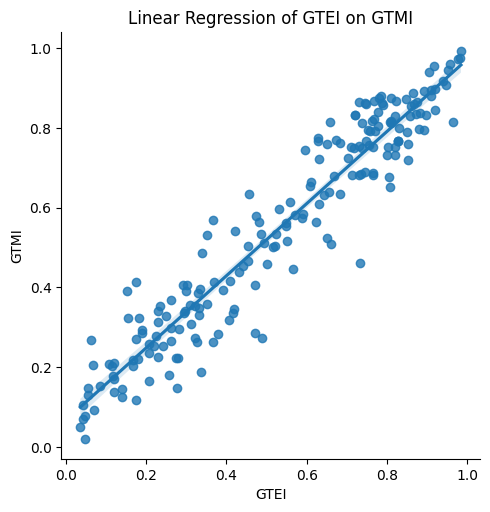

In [29]:
simpleLin = sns.lmplot(data=govtech_gdp, x='GTEI', y='GTMI')
simpleLin.set(title='Linear Regression of GTEI on GTMI')
simpleLin.savefig(r'simpleLinear.png')

Our next question is does this change significantly if we bring in our independent variables to control for OVB: Income Level, Population, and GDP?

In this case, we are going to leverage statsmodels for more complete linear regression.

In [30]:
# Import statsmodels
import statsmodels.formula.api as smf

In [31]:
# Create dummy variables out of the IncomeLevel categorical variable
dummies=pd.get_dummies(govtech_gdp['IncomeLevel'], prefix='IL', drop_first = True)
# Add the resulting dummies into the larger data set
govtech_gdp['IL_LM'] = dummies['IL_LM']
govtech_gdp['IL_UM'] = dummies['IL_UM']
govtech_gdp['IL_H'] = dummies['IL_H']


In [32]:

# Add in our independent variables to account for OVB, including the dummies created for IncomeLevel
model = smf.ols('GTMI ~ GTEI + logPopulation + logGDP + IL_LM + IL_UM + IL_H', data=govtech_gdp)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   GTMI   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     360.3
Date:                Tue, 30 May 2023   Prob (F-statistic):           2.12e-96
Time:                        15:35:12   Log-Likelihood:                 227.40
No. Observations:                 184   AIC:                            -440.8
Df Residuals:                     177   BIC:                            -418.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0033      0.153      0.022      0.983      -0.298       0.305
IL_LM[T.True]     0.0201      0.023      0.874      0.383      -0.025       0.066
IL_UM[T.True]     0.0648      0.033      1.984      0.049       0.000       0.129
IL_H[T.True]      0.0504      0.048      1.054      0.294      -0.044       0.145
GTEI              0.8576      0.029     29.841      0.000       0.801       0.914
logPopulation     0.0068      0.012      0.590      0.556      -0.016       0.030
logGDP           -0.0002      0.011     -0.022      0.983      -0.022       0.022
==============================================================================
Omnibus:                        2.431   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.297   Jarque-Bera (JB):                2.246
Skew:                          -0.101   Prob(JB):                        0.325
Kurtosis:                       3.502   Cond. No.                         796.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In the output from the above, we see a slightly smaller coefficient for the GTEI score, 0.8576, compared to 0.9053 on the simple regression. This score remains significant with a t-score of 29.8, and an extremely small p-value (5.642e-71). Again, this is not a surprise, as the GTEI score is one of 4 used to generate the GTMI score.

However, the GTEI score itself is comprised of 56 separate numerical scores, some weighted. Of these, 23 scores fall to the category of _Human Capital_, including the 7 scores we are most interested in, relating to Technical Skills enablement.

With a  baseline regression provided above, we can now examine what influence these individual scores have on a government organization's overall Tech Maturity (GTMI). Note that these Technical Skills variables all have limited values, some binary (0 or 1), and some with only three values (0,1,2 or 1,2,3). For this reason, they can be considered categorical to some extent. As each score is ordered, i.e. the higher the number the higher the level of skills enablement, they can still be used for the regression analysis.

In this analysis, I am performing two regressions:
1. A regression on GTMI for all Tech Skills enablement variables.
2. A regression on GTEI, the Tech Enablement specific aspect of GTMI.

In [33]:
# Build complete regression for GTMI
model = smf.ols('GTMI ~ DS_Strategy_Program + FocusArea + DSProgram + DSProgramType + \
                DSProgramMandatory + DSProgramExternal + DSProgramPublished +\
                logPopulation + logGDP + IL_LM + IL_UM + IL_H',    # Control variables for OVB
                data=govtech_gdp)
results = model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   GTMI   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     44.21
Date:                Tue, 30 May 2023   Prob (F-statistic):           4.36e-46
Time:                        15:35:18   Log-Likelihood:                 119.79
No. Observations:                 184   AIC:                            -213.6
Df Residuals:                     171   BIC:                            -171.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.3613      0.285     -1.268      0.206      -0.924       0.201
IL_LM[T.True]           0.0658      0.043      1.532      0.127      -0.019       0.151
IL_UM[T.True]           0.1732      0.061      2.844      0.005       0.053       0.293
IL_H[T.True]            0.2180      0.090      2.435      0.016       0.041       0.395
DS_Strategy_Program     0.0359      0.022      1.603      0.111      -0.008       0.080
FocusArea               0.0267      0.012      2.238      0.027       0.003       0.050
DSProgram              -0.0443      0.058     -0.764      0.446      -0.159       0.070
DSProgramType           0.0634      0.024      2.694      0.008       0.017       0.110
DSProgramMandatory      0.0233      0.023      0.994      0.322      -0.023       0.070
DSProgramExternal       0.0300      0.018      1.714      0.088      -0.005       0.065
DSProgramPublished      0.0215      0.015      1.445      0.150      -0.008       0.051
logPopulation           0.0195      0.022      0.902      0.368      -0.023       0.062
logGDP                  0.0185      0.021      0.878      0.381      -0.023       0.060
==============================================================================
Omnibus:                        0.287   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.866   Jarque-Bera (JB):                0.100
Skew:                          -0.037   Prob(JB):                        0.951
Kurtosis:                       3.087   Cond. No.                         820.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The regression outcome indicates significant results (at the 95% Confidence Level) for FocusArea and DSProgramType (T-value > 1.96). Both also show a p-value below alpha = 0.05. 
* _FocusArea_ is an indication of the type of Tech Skills provided: 0=Unknown, 1=Basic digital skills, 2=Basic digital skills + Data literacy, 3=Advanced digital skills + data literacy.
* _DSProgramType_ is an indication of the type of learning program provided: 1=Academic program, 2=Public sector program, 3=CSO/Private program.
However, the coefficient on both variables is small: 0.0267 (0.012) and 0.0634 (0.024) respectively. This indicates that these variables have a definite influence on the GTMI score, but a small influence.

We can also consider GTEI, the GovTech Enablers Index, as a measurement in itself, i.e. does the government organization enable technical capabilities through the policies and programs that foster Technical Maturity. GTEI, as we saw, has a direct correlation to GTMI, and includes the Tech Skills variables.

In [34]:
# Build complete regression for GTEI
model = smf.ols('GTEI ~ DS_Strategy_Program + FocusArea + DSProgram + DSProgramType + \
                DSProgramMandatory + DSProgramExternal + DSProgramPublished +\
                logPopulation + logGDP + IL_LM + IL_UM + IL_H',    # Control variables for OVB
                data=govtech_gdp)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   GTEI   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     56.12
Date:                Tue, 30 May 2023   Prob (F-statistic):           7.43e-53
Time:                        15:35:28   Log-Likelihood:                 125.88
No. Observations:                 184   AIC:                            -225.8
Df Residuals:                     171   BIC:                            -184.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.3848      0.276     -1.396      0.164      -0.929       0.159
IL_LM[T.True]           0.0501      0.042      1.206      0.230      -0.032       0.132
IL_UM[T.True]           0.1281      0.059      2.174      0.031       0.012       0.244
IL_H[T.True]            0.2059      0.087      2.378      0.019       0.035       0.377
DS_Strategy_Program     0.0712      0.022      3.283      0.001       0.028       0.114
FocusArea               0.0203      0.012      1.758      0.080      -0.002       0.043
DSProgram              -0.0351      0.056     -0.625      0.533      -0.146       0.076
DSProgramType           0.0544      0.023      2.391      0.018       0.009       0.099
DSProgramMandatory      0.0262      0.023      1.155      0.250      -0.019       0.071
DSProgramExternal       0.0325      0.017      1.922      0.056      -0.001       0.066
DSProgramPublished      0.0367      0.014      2.550      0.012       0.008       0.065
logPopulation           0.0162      0.021      0.774      0.440      -0.025       0.058
logGDP                  0.0194      0.020      0.955      0.341      -0.021       0.060
==============================================================================
Omnibus:                        0.532   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.766   Jarque-Bera (JB):                0.256
Skew:                          -0.042   Prob(JB):                        0.880
Kurtosis:                       3.163   Cond. No.                         820.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Once again, _FocusArea_ and _DSProgramType_ stand out with strong t-scores and p-values, though FocusArea is significant only at the 90% level. Additionally, _DS_Strategy_Program_ and _DSProgramPublished_ also demonstrate signficance at the 95% Confidence Level. As before, though, all four variables have small coefficients. Of the four, _DS_Strategy_Program_ has the highest coefficient at 0.0712. Values for _DS_Strategy_Program_ are:
* 0=No Strategy or Program for digital skills exists
* 1=Yes, but only one or the other (Strategy or Program) exists
* 2=Both a Strategy and a Program for digital skills enablement exists.

With a value of 2, the presence of both a Digital Skills Strategy and an internal Program, the GTEI score is increased by a score of 0.1424. The value of this could be further analyzed based on the various groupings of the governments accoridng to the Group variable. In other words, does that value of 0.1424 move the government up one level in maturity?
According to the GovTech Maturity Index document (page 31), average GTEI values for the 4 Maturity groups are: A=0.845, B=0.648, C=0.362, and D=0.144. The smallest difference between those four levels is 0.197 between Group A and Group B, less than the 0.1424 coefficient that a _DS_Strategy_Program_ value of 2 would provide.

## Regression of Project Outcomes
With little influence of Tech Skills on the overall Tech Maturity of a Govenrment organization, we can now consider the influence of Tech Skills on the outcome of individual projects. Our Project data includes two binary classifiers: ICROutcomeB and IEGOutcomeB. These are based on the categorical values of ICROutcome and IEGOutcome, which are two separate evaluations of the outcome of individual Tech projects. As these are binary classifiers, correlation and linear regression are not good measurements, and we will examine Logistic regression instead.

In [35]:
projects_gtmi.head()

,ProjectID,ICROutcome,IEGOutcome,ICROutcomeB,IEGOutcomeB,Code,Country,Population,IncomeLevel,Region,...,DCEI,GTEI,DS_Strategy_Program,FocusArea,DSProgram,DSProgramType,DSProgramMandatory,DSProgramExternal,DSProgramPublished,GDP2021
0,P006661,S,S,1,1,CHL,Chile,19493.184,H,LCR,...,0.681820,0.728947,2,2,1,2,1,1,0,3.170585e+11
1,P078359,HS,HS,1,1,TUR,Türkiye,84775.404,UM,ECA,...,0.847791,0.846981,2,3,1,2,1,2,1,8.190352e+11
2,P058512,S,S,1,1,BIH,Bosnia and Herzegovina,3270.943,UM,ECA,...,0.159717,0.176278,0,0,0,0,0,0,0,2.336536e+10
3,P079708,S,S,1,1,IND,India,1407563.842,LM,SAR,...,0.954961,0.903784,2,3,1,2,1,2,2,3.176295e+12
4,P102398,HS,S,1,1,LAO,Lao PDR,7425.057,LM,EAP,...,0.432448,0.369742,0,0,0,0,0,0,0,1.882715e+10


In this analysis, I am starting with Generalized Linear Models (GLM) from _statsmodels_. Then I will use Logit models from _SciKit Learn_. With both, I hope to have a complete picture of the level of influence on project success offered by the Tech Enablement and Tech Skills varaibles.

First we need to prepare our Control varaibles by calculating the Log values of Population and GDP and converting IncomeLevel into dummy values.

In [36]:
# Add Log values of Population and GDP to the data set
projects_gtmi['logPopulation'] = np.log(projects_gtmi['Population'])
projects_gtmi['logGDP'] = np.log(projects_gtmi['GDP2021'])

# Convert the IncomeLevel column to categorical
projects_gtmi['IncomeLevel'] = projects_gtmi['IncomeLevel'].astype(cat_dtype)
# Create dummy variables out of the IncomeLevel categorical variable
dummies=pd.get_dummies(projects_gtmi['IncomeLevel'], prefix='IL', drop_first = True)
# Add the resulting dummies into the larger data set
projects_gtmi['IL_LM'] = dummies['IL_LM']
projects_gtmi['IL_UM'] = dummies['IL_UM']
projects_gtmi['IL_H'] = dummies['IL_H']

Now we can use a Generalized Linear Model (GLM) from the statsmodels library. Here we start with the ICROutcome bivariate variable.

In [37]:
# Logistic regression on ICROutcome binary variable using statsmodels
model_icr = smf.glm('ICROutcomeB ~ DS_Strategy_Program + FocusArea + DSProgram + DSProgramType + \
                    DSProgramMandatory + DSProgramExternal + DSProgramPublished +\
                    logPopulation + logGDP + IL_LM + IL_UM + IL_H',    # Control variables for OVB
                    data=projects_gtmi)
results_icr = model_icr.fit()
results_icr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            ICROutcomeB   No. Observations:                  964
Model:                            GLM   Df Residuals:                      951
Model Family:                Gaussian   Df Model:                           12
Link Function:               Identity   Scale:                         0.14883
Method:                          IRLS   Log-Likelihood:                -443.14
Date:                Tue, 30 May 2023   Deviance:                       141.54
Time:                        15:35:47   Pearson chi2:                     142.
No. Iterations:                     3   Pseudo R-squ. (CS):            0.01617
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.2287      0.467      0.489      0.625      -0.687       1.145
IL_LM[T.True]          -0.0030      0.059     -0.051      0.959      -0.118       0.112
IL_UM[T.True]           0.0017      0.096      0.018      0.986      -0.186       0.189
IL_H[T.True]           -0.0300      0.130     -0.232      0.817      -0.284       0.224
DS_Strategy_Program     0.0058      0.030      0.195      0.845      -0.052       0.064
FocusArea              -0.0089      0.017     -0.538      0.591      -0.041       0.024
DSProgram               0.2417      0.099      2.447      0.014       0.048       0.435
DSProgramType          -0.0687      0.041     -1.692      0.091      -0.148       0.011
DSProgramMandatory     -0.0343      0.031     -1.097      0.273      -0.096       0.027
DSProgramExternal      -0.0325      0.026     -1.242      0.214      -0.084       0.019
DSProgramPublished      0.0113      0.021      0.536      0.592      -0.030       0.052
logPopulation          -0.0400      0.037     -1.082      0.279      -0.112       0.032
logGDP                  0.0398      0.035      1.126      0.260      -0.029       0.109
=======================================================================================
"""

Next is the IEGOutcomeB variable.

In [38]:
# Logistic regression on IEGOutcome binary variable using statsmodels
model_ieg = smf.glm('IEGOutcomeB ~ DS_Strategy_Program + FocusArea + DSProgram + DSProgramType + \
                    DSProgramMandatory + DSProgramExternal + DSProgramPublished +\
                    logPopulation + logGDP + IL_LM + IL_UM + IL_H',    # Control variables for OVB
                    data=projects_gtmi)
results_ieg = model_ieg.fit()
results_ieg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            IEGOutcomeB   No. Observations:                  964
Model:                            GLM   Df Residuals:                      951
Model Family:                Gaussian   Df Model:                           12
Link Function:               Identity   Scale:                         0.21269
Method:                          IRLS   Log-Likelihood:                -615.22
Date:                Tue, 30 May 2023   Deviance:                       202.27
Time:                        15:35:53   Pearson chi2:                     202.
No. Iterations:                     3   Pseudo R-squ. (CS):            0.03854
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.1975      0.559      0.354      0.724      -0.897       1.292
IL_LM[T.True]           0.0590      0.070      0.839      0.401      -0.079       0.197
IL_UM[T.True]           0.1568      0.114      1.370      0.171      -0.068       0.381
IL_H[T.True]            0.1639      0.155      1.059      0.290      -0.139       0.467
DS_Strategy_Program     0.0528      0.035      1.497      0.135      -0.016       0.122
FocusArea              -0.0251      0.020     -1.267      0.205      -0.064       0.014
DSProgram               0.1350      0.118      1.143      0.253      -0.096       0.366
DSProgramType          -0.0134      0.049     -0.275      0.783      -0.109       0.082
DSProgramMandatory     -0.0252      0.037     -0.673      0.501      -0.099       0.048
DSProgramExternal      -0.0488      0.031     -1.558      0.119      -0.110       0.013
DSProgramPublished      0.0182      0.025      0.725      0.468      -0.031       0.067
logPopulation          -0.0271      0.044     -0.614      0.539      -0.114       0.060
logGDP                  0.0255      0.042      0.604      0.546      -0.057       0.108
=======================================================================================
"""

With the GLM models established, we can now repeat the analysis with Logit models. We start with the _ICROutcomeB_ variable again.

In [39]:
## Logistic Regression imported from SciKit Learn

# We need numy to build arrays for the logistic model
import numpy as np
# import sklearn libraries
from sklearn.linear_model import LogisticRegression


In [40]:
## Build numpy arrays out of the data frame variables

# Pull out the independent variables from the data frame
# and turn them into a numpy 2D array
columns = ['DS_Strategy_Program','FocusArea', 'DSProgram', 'DSProgramType', 'DSProgramMandatory', 'DSProgramExternal']
controls = ['logPopulation', 'IL_LM', 'IL_UM', 'IL_H']

# Establish oru array of predictors
predictors = np.array(projects_gtmi[columns + controls])
# Turn the dependent variable into a numpy array as well.
# We start with the ICR Outcome variable.
outcome_icr = np.array(projects_gtmi['ICROutcomeB'])
# Reshape the outcome varaible into a 2D array
outcome_icr = outcome_icr.reshape(-1,1)

In [41]:
# Create base LogisticRegression function
logit_icr = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
# Generate the model based on the arrays created above.
logit_icr.fit(X=predictors, y=outcome_icr)


c:\Users\jomors\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1e+42, solver='liblinear')

In [43]:
## Calculate Standard Errors through a covariance matrix.
## SciKit-Learn does not support this directly.

# Calculate matrix of predicted class probabilities.
predProbs_icr = logit_icr.predict_proba(predictors)

# Design matrix -- add column of 1's at the beginning of yoru predictors matrix
X_design = np.hstack([np.ones((predictors.shape[0], 1)), predictors])
# Initiate matrix of 0s, fill diagonal with each predicted observation's variance
V = np.diagflat(np.product(predProbs_icr, axis=1))

# Covariance matrix
covLogit = np.linalg.inv(np.dot(np.dot(predictors.T, V), predictors).astype(np.float64))

# Standard errors
coef_se = np.sqrt(np.diag(covLogit))

In [44]:
## Print out Intercept and coefficients for refernece
print(f'Intercept: {logit_icr.intercept_}')
print(pd.DataFrame({'coeff': logit_icr.coef_[0], 'se': coef_se},index=columns + controls))

Intercept: [1.01441812]
                        coeff        se
DS_Strategy_Program  0.093959  0.196269
FocusArea           -0.028205  0.109680
DSProgram            1.643071  0.699899
DSProgramType       -0.449007  0.273225
DSProgramMandatory  -0.236709  0.214749
DSProgramExternal   -0.209833  0.182780
logPopulation       -0.000003  0.020397
IL_LM                0.316712  0.225233
IL_UM                0.689119  0.235587
IL_H                 0.650387  0.415727


Now repeat the process for the _IEGOutcomeB_ variable.

In [45]:
# Turn the dependent variable into a numpy array.
# Note that we will use the saem predictors as before.
outcome_ieg = np.array(projects_gtmi['IEGOutcomeB'])
# Reshape the outcome varaible into a 2D array
outcome_ieg = outcome_ieg.reshape(-1,1)

# Create base LogisticRegression function
logit_ieg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
# Generate the model based on the arrays created above.
logit_ieg.fit(X=predictors, y=outcome_ieg)

c:\Users\jomors\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1e+42, solver='liblinear')

In [47]:
# Calculate Standard Errors through a covariance matrix.
## SciKit-Learn does not support this directly.

# Calculate matrix of predicted class probabilities.
predProbs_ieg = logit_ieg.predict_proba(predictors)

# Design matrix -- add column of 1's at the beginning of yoru predictors matrix
X_design = np.hstack([np.ones((predictors.shape[0], 1)), predictors])
# Initiate matrix of 0s, fill diagonal with each predicted observation's variance
V = np.diagflat(np.product(predProbs_icr, axis=1))

# Covariance matrix
covLogit = np.linalg.inv(np.dot(np.dot(predictors.T, V), predictors).astype(np.float64))

# Standard errors
coef_se = np.sqrt(np.diag(covLogit))

In [48]:
## Print out Intercept and coefficients for refernece
print(f'Intercept: {logit_ieg.intercept_}')
print(pd.DataFrame({'coeff': logit_ieg.coef_[0], 'se': coef_se},index=columns + controls))

Intercept: [0.13504879]
                        coeff        se
DS_Strategy_Program  0.253135  0.196269
FocusArea           -0.107691  0.109680
DSProgram            0.616878  0.699899
DSProgramType       -0.047973  0.273225
DSProgramMandatory  -0.095916  0.214749
DSProgramExternal   -0.216946  0.182780
logPopulation       -0.006196  0.020397
IL_LM                0.390215  0.225233
IL_UM                1.003117  0.235587
IL_H                 1.108949  0.415727


### Prediciton with Logistic Models
With these logistic models, the most important question is at what rate they predict correctly. We can begin with the GLM models from statsmodels.

In [49]:
## For the statsmodels GLM models, we will simply compare the predicted 
## number of 1s to the actual number of 1s provided in the origninal data.

# For ICROutcome, what percentage are actaully 1
act_icr = np.array(projects_gtmi['ICROutcomeB'])
act_icr_pct = sum(act_icr) / np.shape(act_icr)[0]
# Based on a threshold > 0.5, what percentage were predicted to be 1
pred_icr = results_icr.predict()
pred_icr_pct = sum(pred_icr > 0.5) / np.shape(pred_icr)[0]
# Print out the results
print('ICR Outcome Results')
print(f'Actual Percent of Satisfactory Results: {act_icr_pct:.4f}')
print(f'Predicted Percent of Satisfactory Results: {pred_icr_pct:.4f}')

print('\n')
# For IEGOutcome, what percentage are actaully 1
act_ieg = np.array(projects_gtmi['IEGOutcomeB'])
act_ieg_pct = sum(act_ieg) / np.shape(act_ieg)[0]
# Based on a threshold > 0.5, what percentage were predicted to be 1
pred_ieg = results_ieg.predict()
pred_ieg_pct = sum(pred_ieg > 0.5) / np.shape(pred_ieg)[0]
# Print out the results
print('IEG Outcome Results')
print(f'Actual Percent of Satisfactory Results: {act_ieg_pct:.4f}')
print(f'Predicted Percent of Satisfactory Results: {pred_ieg_pct:.4f}')



ICR Outcome Results
Actual Percent of Satisfactory Results: 0.8138
Predicted Percent of Satisfactory Results: 1.0000


IEG Outcome Results
Actual Percent of Satisfactory Results: 0.6787
Predicted Percent of Satisfactory Results: 0.9803


Predicted outcomes are significantly higher than actual results, indicating these are not good models for predicting Project Success.

Now we can consider the Logit models from _SciKit-Learn_. SciKit-Learn includes a classification report that allows us to quickly asses the accuracy of prediction with the models based on the original data provided.

In [50]:
from sklearn.metrics import classification_report

In [51]:
# Print Classification report for ICR Outcome
print('Classification Report: ICR Outcome from Logit Model')
print(classification_report(outcome_icr, logit_icr.predict(predictors)))

# Print a newline
print('\n')

# Print Classification report for ICR Outcome
print('Classification Report: IEG Outcome from Logit Model')
print(classification_report(outcome_ieg, logit_ieg.predict(predictors)))


Classification Report: ICR Outcome from Logit Model
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       186
           1       0.81      1.00      0.90       813

    accuracy                           0.81       999
   macro avg       0.41      0.50      0.45       999
weighted avg       0.66      0.81      0.73       999



Classification Report: IEG Outcome from Logit Model
              precision    recall  f1-score   support

           0       0.38      0.01      0.02       321
           1       0.68      0.99      0.81       678

    accuracy                           0.68       999
   macro avg       0.53      0.50      0.41       999
weighted avg       0.58      0.68      0.55       999



c:\Users\jomors\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jomors\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jomors\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

A quick look at the accuracy of each model showws results identical to the GLM model from statsmodels.
* ICR Outcome has and accuracy of 81%
* IEG Outcome has an accuracy of 68%

Although 81% sounds high, we must recall that the actual percentage of Success ratings for the ICR Outcome is 81%, indicating that, essentially, all projects are being predicted as successful based on the model. The same is the case with the IEG model. Neither model proves valuable in predicitn success of projects.

## Conclusion

The models implemented in this analysis show no significant influence of the Tech Skills or Tech Enablment variables on either the overall Tech Maturity (GTMI) score or on the success of individual projects. Although there are many opportunities to refine this analysis based on the variables used, and groupings of governement organizations avaialble in the data, the immediate conclusion shows not relationship.